# BREAST CANCER SEGMENTATION

Installing libraries:

In [15]:
pip install pathlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
 pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install tf_explain

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install ipyvolume

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pathlib 
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import timeit
import numpy as np 
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate
from tensorflow.keras.utils import img_to_array


# Reading the dataset

Reading files using OS module which is used for interacting with the operating system

The OS module contains functions to get information on local directories, files, processes, and environment variables.

In [2]:
path = '/Users/tejalpatel/Downloads/Dataset_BUSI_with_GT_2/'
data_dir = pathlib.Path(path)
print(data_dir)

/Users/tejalpatel/Downloads/Dataset_BUSI_with_GT_2


In [4]:
import os
  
# Get the list of all files and directories
# in the root directory
path = "/Users/tejalpatel/Downloads/Dataset_BUSI_with_GT_2/"
dir_list = os.listdir(path)
  
print("Files and directories in '", path, "' :") 
  
# print the list
print(dir_list)

Files and directories in ' /Users/tejalpatel/Downloads/Dataset_BUSI_with_GT_2/ ' :
['malignant', 'benign', 'normal']


Input dataset is divided into 3 categories:

In [5]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['benign', 'malignant', 'normal'], dtype='<U9')

In [6]:
benignPath = os.path.join(data_dir,'benign')
malignantPath = os.path.join(data_dir,'malignant')
normalPath = os.path.join(data_dir,'normal')

Counting number of images in the dataset:

In [7]:
imageCount = len(list(data_dir.glob('*/*.png')))
imageCount

1578

In [8]:
def num (image) :
    
    val = 0
    
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

X: Original image

y: Mask image

In [9]:
#x for images 
#y for masks
#t for target"label"
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m= np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [10]:
for i, tumor_type in enumerate(os.listdir(path )) :
    for image in os.listdir(path +tumor_type+'/') :
        p = os.path.join(path +tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

In [11]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [12]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [13]:
 X.shape , y.shape

((780, 128, 128, 1), (780, 128, 128, 1))

In [14]:
y.max() , y.min()

(510.0, 0.0)

In [15]:
## Normalization
X /= 255
y /= 255

In [16]:
X.max() , y.min()

(1.0, 0.0)

In [17]:
## get extract image number from image name
def extract_number(image):
    return int(image.split("(")[1].split(")")[0])

In [18]:
## test extract_number()
x = os.listdir(path + "benign" )
extract_number(x[20])

410





Converting Image to single channel

Grayscale images are single-channeled images in which each pixel carries only information about the intensity of light.

In [19]:
def convertToOneChannel(img):
   im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
   i=cv2.resize(im, (128, 128))
   return i

Converting Image into three channel 

Unlike grayscale images, RGB images are three channeled. Each pixel is made up of three channels, with each channel representing a colour.

In [20]:
   def convertToThreeChannel(img):
       b_np= np.array(img)
       g_np= np.array(img)
       r_np= np.array(img)
       final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
       return np.array(final_img)

# Visualizing Images

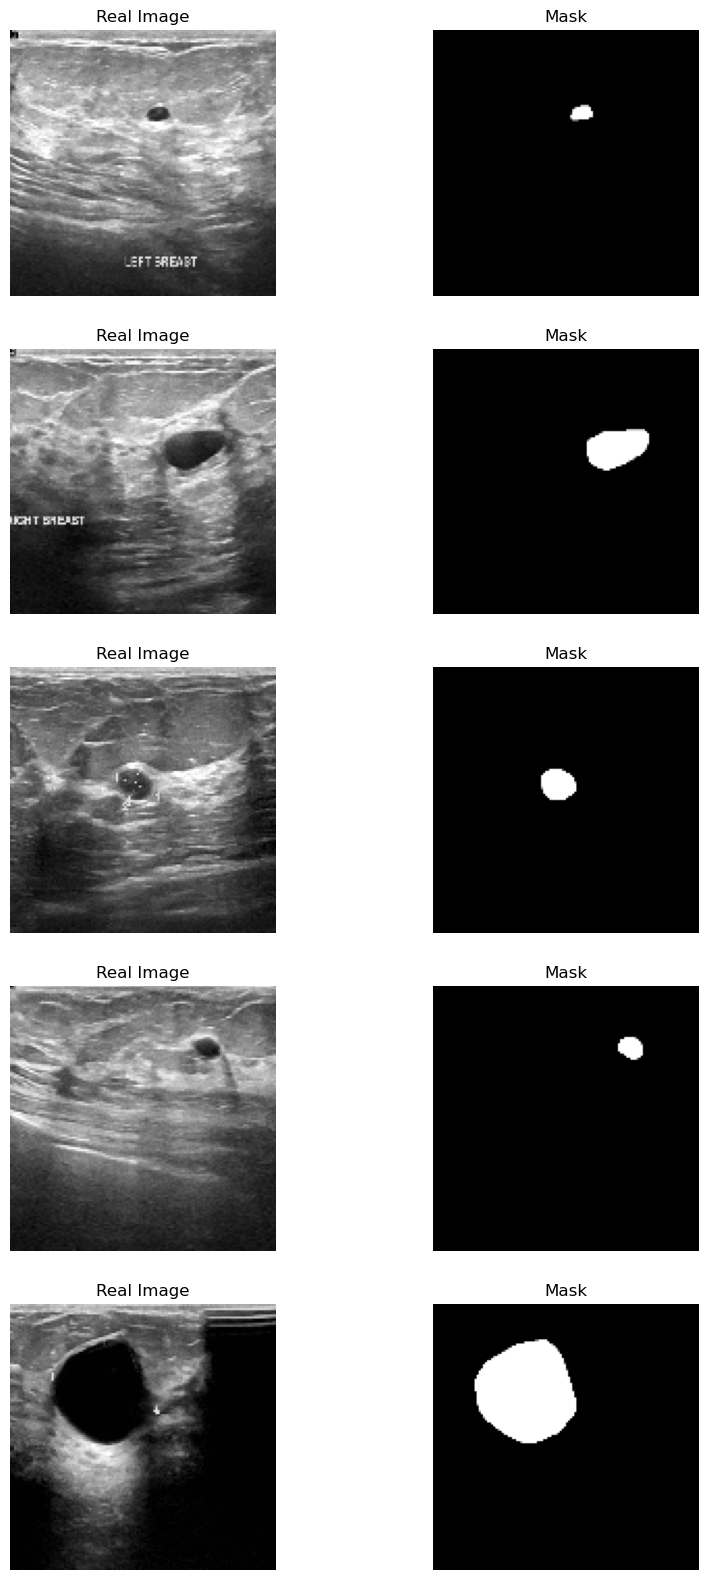

In [23]:
plt.figure(figsize= (10,20))
i = 0 
while i < 10:
    x = np.random.randint(0,255)
    plt.subplot(5,2,i+1)
    plt.imshow(X[i], 'gray')
    plt.title("Real Image")
    plt.axis("off")
    plt.subplot(5,2,i+2)
    plt.imshow(y[i], 'gray')
    plt.title("Mask")
    plt.axis("off")
    i += 2

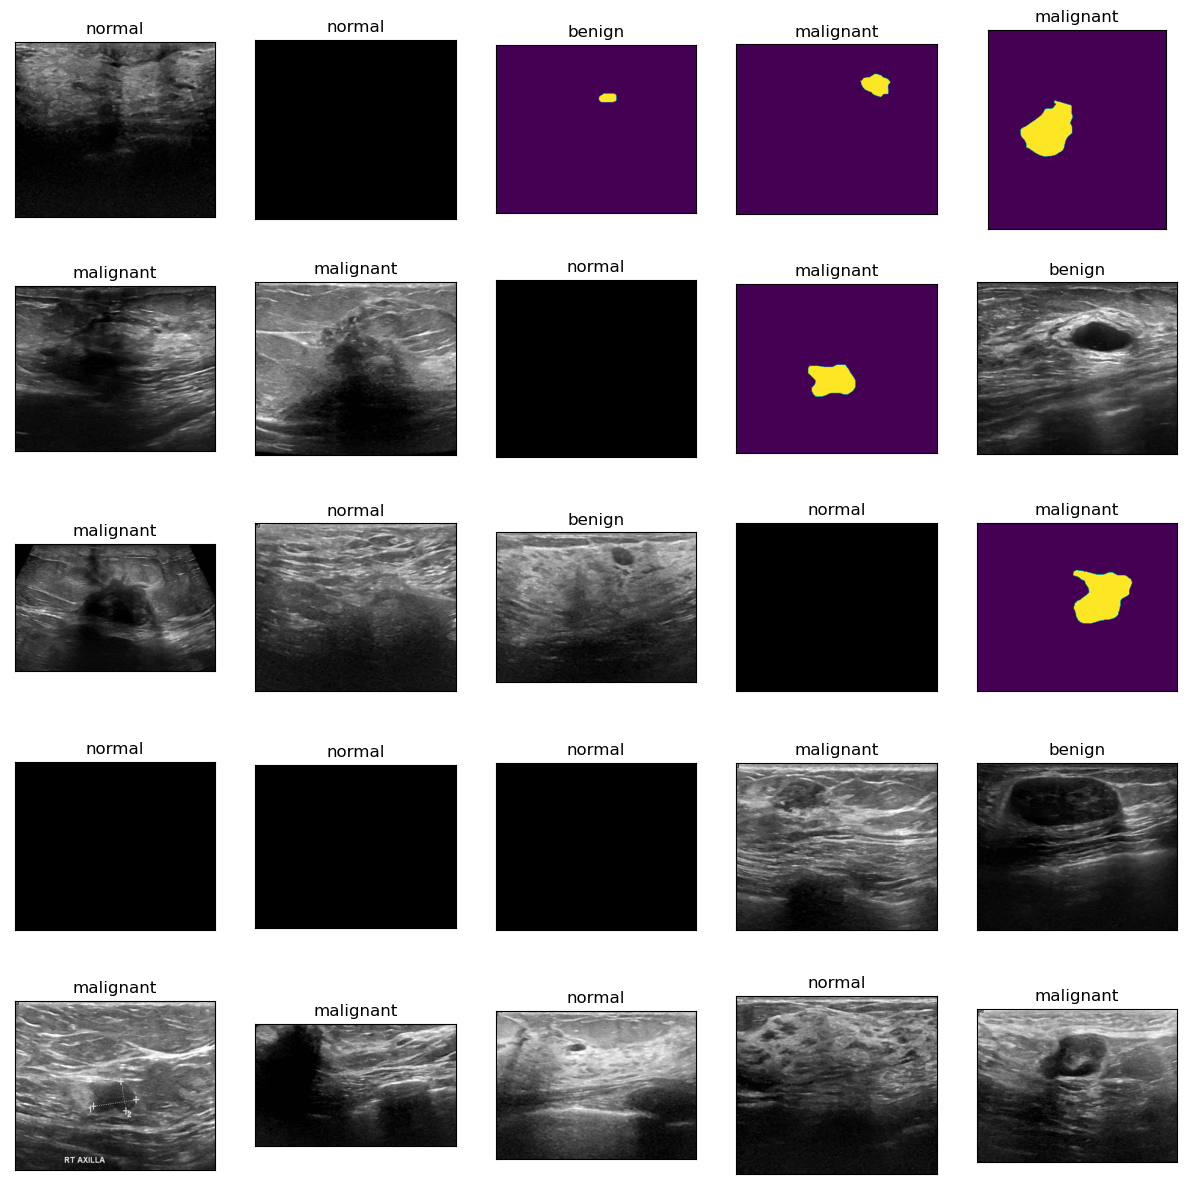

In [24]:
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    random_class = random.choice(class_names)
    img = plt.imread(random.choice(list(data_dir.glob(random_class+"/*.png"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)

In [25]:
from pathlib import Path
import imghdr

data_dir = '/Users/tejalpatel/Downloads/Dataset_BUSI_with_GT/'
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

# Data Augmentation

What is data augmentation?

Derived from original images with some sort of minor geometric transformations (such as flipping, translation, rotation, or the addition of noise) in order to increase the diversity of the training set.


Importance of data augmentation?

1)Improves the performance of ML models (more diverse datasets).

2)Reduces operation costs related to data collection

In [26]:
actual=[]
mask=[]
for i in X:
  horizontal_flip = cv2.flip(i, 1)
  vertical_horizontal_flip = cv2.flip(i, -1)
  imagerotate = cv2.rotate(i, cv2.ROTATE_180) 
  imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
  imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
  actual.append(horizontal_flip)
  actual.append(vertical_horizontal_flip)
  actual.append(imagerotate)
  actual.append(imagerotate1)
  actual.append(imagerotate2)
  

for j in y:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)

In [27]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


Normalizing the images by dividing the images with their color information by 255 to obtain numbers between 0 and 1

In [28]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

0.00784313725490196
0.0


In [30]:
mask[mask > 1.0] = 1.0

In [31]:
print(mask.max())
print(mask.min())

1.0
0.0


In [32]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [33]:
#Return a new array of given shape and type, filled with fill_value.
t1=np.full(2185,1) 
t2=np.full(665,0)
t3=np.full(1050,2)  
T=np.concatenate((t1, t2, t3), axis = 0)
T=np.array(T)

In [34]:
print(T.shape)

(3900,)


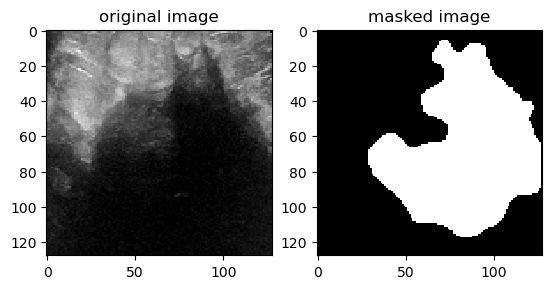

In [35]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title("masked image")
plt.show()

# Data Split

In machine learning, data splitting is typically done to avoid overfitting. That is an instance where a machine learning model fits its training data too well and fails to reliably fit additional data.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(actual, mask, test_size = 0.15, random_state = 1)

In [37]:
batch_size = 32
img_height = 224
img_width = 224

In [38]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
                  data_dir,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)


val_data = image_dataset_from_directory(data_dir,
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=123,
                                        image_size=(img_height,img_width),
                                        batch_size=batch_size)

Found 780 files belonging to 3 classes.
Using 624 files for training.
Metal device set to: Apple M1 Pro


2022-11-21 18:08:01.309600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-21 18:08:01.310241: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 780 files belonging to 3 classes.
Using 156 files for validation.


# Implementing Model

Semantic Segmentation: 

It is a technique with enables us to differentiate different objects in an image. In other words it label each pixel of an image with a corresponding class of what is being represented. Because we’re predicting for every pixel in the image, this task is commonly referred to as dense prediction.

Step I: 
Convolution: 

a)A 3D volume (input image) of size.

b) A set of k filters also called kernels or feature extractor

StepII:
Max Pooling Opertion: Function of pooling is to reduce the size of the filter so that we have fewer parameters in the network.

StepIII:
Transposed Convolution: also called as deconvolution or fractionally strided convolution, is a technique to perform up sampling of an image with learnable parameters.





In [39]:
inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

In [40]:
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

In [41]:
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [42]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

In [43]:
from keras.metrics import MeanIoU

In [44]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['acc'])
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

 concatenate_3 (Concatenate)    (None, 128, 128, 12  0           ['conv2d_transpose_3[0][0]',     
                                8)                                'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_16[0][0]']              
                                )                                                                 
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 64  0           ['conv2d_17[0][0]']              
          

In [45]:
from keras.callbacks import ModelCheckpoint

# U-NET 

The architecture contains two paths. First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

In [46]:
checkp = ModelCheckpoint('./unet_model.h5', monitor = 'accuracy', save_best_only = True, verbose = 1)

EPOCHS: An epoch is when all the training data is used at once and is defined as the total number of iterations of all the training data in one cycle for training the machine learning model. 

In [47]:
epochs = range(100)

In [48]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 16, validation_data = (X_test, y_test), callbacks = [checkp])


Epoch 1/100


2022-11-21 18:08:56.458869: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-21 18:08:57.066245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 0.0743 - acc: 0.9192

2022-11-21 18:10:30.225481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 98s 468ms/step - loss: 0.0743 - acc: 0.9192 - val_loss: 0.0654 - val_acc: 0.9287
Epoch 2/100
208/208 [==============================] - 97s 467ms/step - loss: 0.0700 - acc: 0.9192 - val_loss: 0.0619 - val_acc: 0.9287
Epoch 3/100
208/208 [==============================] - 97s 465ms/step - loss: 0.0693 - acc: 0.9192 - val_loss: 0.0619 - val_acc: 0.9287
Epoch 4/100
208/208 [==============================] - 98s 469ms/step - loss: 0.0662 - acc: 0.9207 - val_loss: 0.0523 - val_acc: 0.9356
Epoch 5/100
208/208 [==============================] - 97s 466ms/step - loss: 0.0512 - acc: 0.9347 - val_loss: 0.0436 - val_acc: 0.9435
Epoch 6/100
208/208 [==============================] - 98s 469ms/step - loss: 0.0467 - acc: 0.9405 - val_loss: 0.0411 - val_acc: 0.9484
Epoch 7/100
208/208 [==============================] - 97s 468ms/step - loss: 0.0444 - acc: 0.9434 - val_loss: 0.0427 - val_acc: 0.9444
Epoch 8/100
208/208 [==============================] - 97s 4

Epoch 57/100
208/208 [==============================] - 96s 462ms/step - loss: 0.0081 - acc: 0.9901 - val_loss: 0.0215 - val_acc: 0.9751
Epoch 58/100
208/208 [==============================] - 97s 465ms/step - loss: 0.0076 - acc: 0.9908 - val_loss: 0.0214 - val_acc: 0.9753
Epoch 59/100
208/208 [==============================] - 97s 465ms/step - loss: 0.0073 - acc: 0.9911 - val_loss: 0.0214 - val_acc: 0.9752
Epoch 60/100
208/208 [==============================] - 97s 464ms/step - loss: 0.0072 - acc: 0.9913 - val_loss: 0.0219 - val_acc: 0.9751
Epoch 61/100
208/208 [==============================] - 97s 465ms/step - loss: 0.0070 - acc: 0.9915 - val_loss: 0.0210 - val_acc: 0.9756
Epoch 62/100
208/208 [==============================] - 97s 465ms/step - loss: 0.0070 - acc: 0.9915 - val_loss: 0.0213 - val_acc: 0.9755
Epoch 63/100
208/208 [==============================] - 100s 481ms/step - loss: 0.0069 - acc: 0.9916 - val_loss: 0.0215 - val_acc: 0.9753
Epoch 64/100
208/208 [==================

Epoch 85/100
208/208 [==============================] - 229s 1s/step - loss: 0.0053 - acc: 0.9934 - val_loss: 0.0210 - val_acc: 0.9760
Epoch 86/100
208/208 [==============================] - 319s 2s/step - loss: 0.0083 - acc: 0.9895 - val_loss: 0.0218 - val_acc: 0.9748
Epoch 87/100
208/208 [==============================] - 229s 1s/step - loss: 0.0065 - acc: 0.9919 - val_loss: 0.0212 - val_acc: 0.9753
Epoch 88/100
208/208 [==============================] - 131s 632ms/step - loss: 0.0053 - acc: 0.9934 - val_loss: 0.0212 - val_acc: 0.9758
Epoch 89/100
208/208 [==============================] - 96s 462ms/step - loss: 0.0050 - acc: 0.9939 - val_loss: 0.0212 - val_acc: 0.9762
Epoch 90/100
208/208 [==============================] - 96s 463ms/step - loss: 0.0050 - acc: 0.9939 - val_loss: 0.0211 - val_acc: 0.9760
Epoch 91/100
208/208 [==============================] - 96s 463ms/step - loss: 0.0047 - acc: 0.9941 - val_loss: 0.0208 - val_acc: 0.9762
Epoch 92/100
208/208 [========================

# Visualize Accuracy and loss Graph


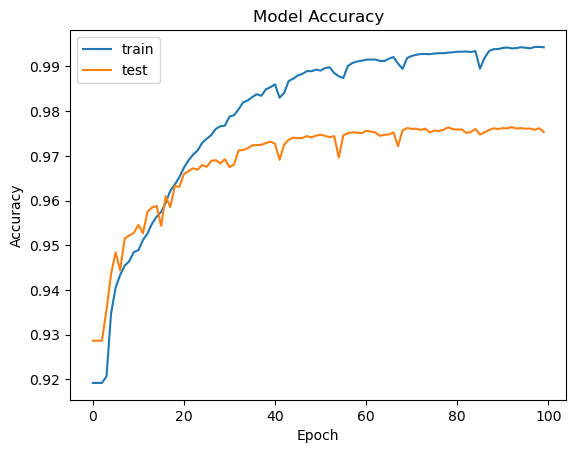

In [49]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

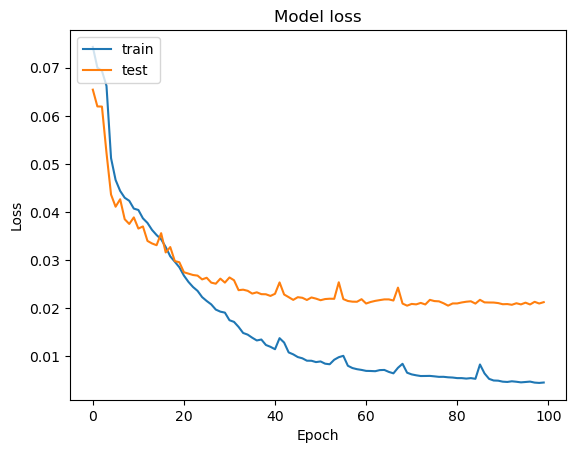

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)

19/19 [==============================] - 5s 237ms/step - loss: 0.0213 - acc: 0.9753
Test loss: 0.021271515637636185
Test accuracy: 97.53420352935791


In [52]:
model.save("finalunet.h5")

In [53]:
def imgpredicting(img):
 x=[]
 x.append(img)
 x=np.array(x)
 output=model.predict(x)
 #print(output)
 output=np.array(output)
 output.shape
 array = np.reshape(output[0], (128, 128))
 print(array.shape)
 return array

2022-11-22 00:18:48.979423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 401ms/step
(128, 128)


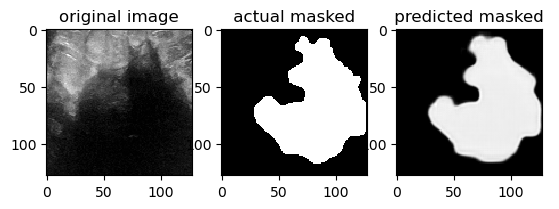

In [54]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[3000]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()

1/1 [==============================] - 0s 19ms/step
(128, 128)


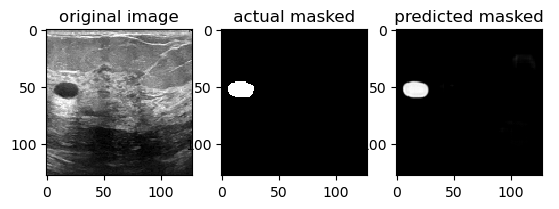

In [55]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[500],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[500],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[500]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()